In [1]:
import os

In [6]:
base_path = "C:/Users/user/Downloads/train_images"
for count, file in enumerate(sorted(os.listdir(base_path))):
    os.rename(f"{base_path}/{file}", f"{base_path}/{count}.jpg")

# Parse scaning images

In [121]:
data_base_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination"
orig_folder = "final_crop"
scan_folder = "final_scan"

In [122]:
all_camera_files = os.listdir(f"{data_base_path}/{orig_folder}")
all_scan_files = os.listdir(f"{data_base_path}/{scan_folder}")

In [123]:
all_camera_names = [file.split('.')[0] for file in all_camera_files]
all_scan_names = [file.split('.')[0] for file in all_scan_files]

In [124]:
print(len(all_camera_names))
print(len(all_scan_names))

522
522


In [125]:
no_cam_names = []
for file in os.listdir(f"{data_base_path}/{scan_folder}"):
    name = file.split('.')[0]#.split('_')[0]
    if name not in all_camera_names:
        no_cam_names.append(name)
        

no_scan_names = []
for file in os.listdir(f"{data_base_path}/{orig_folder}"):
    name = file.split('.')[0]#.split('_')[0]
    if name not in all_scan_names:
        #if name not in no_scan_names:
        no_scan_names.append(name)

In [126]:
print(len(no_cam_names))
print(len(no_scan_names))

0
0


In [119]:
no_cam_names

['소경름_2', '우영구_2', '정수권_2', '정식_2', '조영출_2']

In [120]:
no_scan_names

[]

# Create new folder for final files

In [79]:
from PIL import Image, ImageOps
import numpy as np
import copy

final_orig_folder = "final_camera"
final_scan_folder = "final_scan"


In [80]:
for file in os.listdir(f"{data_base_path}/{scan_folder}"):
    name = file.split('.')[0]#.split('_')[0]
    
    if name in all_camera_names:
        #no_cam_names.append(name)
        base_name = copy.deepcopy(name)
        count = 2
        while name in all_camera_names:
            orig = Image.open(f"{data_base_path}/{scan_folder}/{file}")
            orig.save(f"{data_base_path}/{final_scan_folder}/{name}.jpg")
            
            name = f"{base_name}_{count}"
            count+=1
            
        
        #break

In [81]:
from pillow_heif import register_heif_opener

register_heif_opener()


In [82]:
for file in os.listdir(f"{data_base_path}/{orig_folder}"):
    name = file.split('.')[0].split('_')[0]
    save_name = file.split('.')[0]#.split('_')[0]
    
    if name in all_scan_names:
        orig = Image.open(f"{data_base_path}/{orig_folder}/{file}")
        orig = ImageOps.exif_transpose(orig)

        orig.save(f"{data_base_path}/{final_orig_folder}/{save_name}.jpg")

# Make masks

# Test one

In [83]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

import numpy as np
import random
import copy
import time
from sklearn.model_selection import train_test_split

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "3"


# from utils import CustomDataset, GANLoss, Vgg19
# from generator import AttU_Net
# from discriminator import Discriminator
import cv2
from PIL import Image, ImageOps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [84]:
test_images_base_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/final_camera"
#orig_folder = "final_camera"

i = 0
test_img_path = sorted(os.listdir(test_images_base_path))[i]

In [85]:
num_pixels_x, num_pixels_y, num_channels = 1024, 768, 3

In [86]:
im = Image.open(f"{test_images_base_path}/{test_img_path}")
im = ImageOps.exif_transpose(im)
im = im.resize((num_pixels_y, num_pixels_x))
im = np.array(im)


In [87]:
from models.u2net import U2NETP, U2NET

In [88]:
segment = U2NETP(out_ch=1).to(device)

In [89]:
segmentation_model_path = './weights/mask_0326.pth'

segment.load_state_dict(torch.load(segmentation_model_path))



<All keys matched successfully>

In [90]:
loader = transforms.Compose([transforms.ToTensor()])

In [91]:
image = loader(im).float()
image = image.unsqueeze(0).to(device)

In [92]:
with torch.no_grad():
    mask = segment(image)
    
mask_det = torch.permute(mask[0].detach().cpu(), (0, 2,3, 1)).numpy()
mask_det = mask_det>0.8

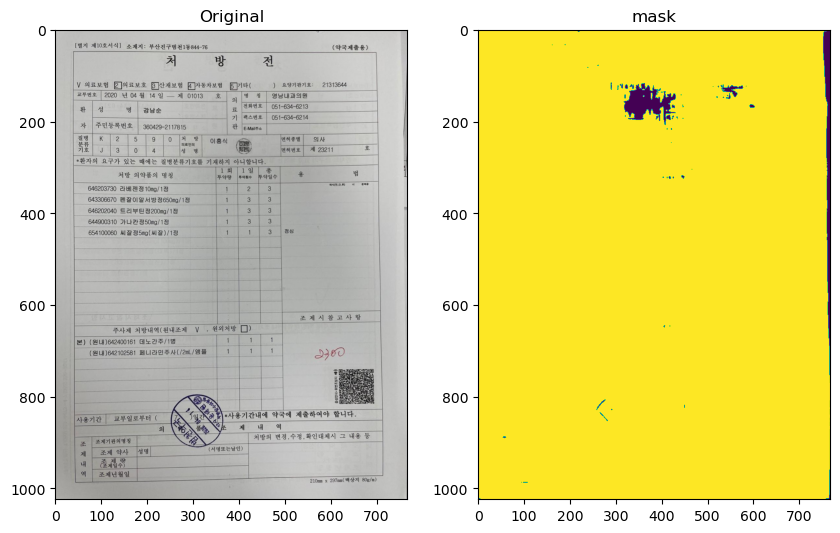

In [93]:
f, axarr = plt.subplots(1,2, figsize=(10,7))

i = -6
#cur_scan = scan_images[i]


axarr[0].imshow(im)
axarr[0].title.set_text('Original')

axarr[1].imshow(mask_det[0])
axarr[1].title.set_text('mask')

# axarr[2].imshow(cur_scan)
# axarr[2].title.set_text('scanned')

In [94]:
mask_to_find = mask_det[0]
mask_to_find = np.array(mask_to_find*255).astype(np.uint8)
contours, hierarchy = cv2.findContours(mask_to_find, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

simplified_contours = []

for cnt in contours:
    hull = cv2.convexHull(cnt)
    simplified_contours.append(cv2.approxPolyDP(hull,
                                                0.001 * cv2.arcLength(hull, True), True))
biggest_n, approx_contour = biggest_contour(simplified_contours, 12192768)

warped = four_point_transform(im, approx_contour)

[[[ 758    2]]

 [[ 763 1021]]

 [[   2 1022]]

 [[   1    2]]]
---------
[[1.000e+00 2.000e+00]
 [7.580e+02 2.000e+00]
 [7.630e+02 1.021e+03]
 [2.000e+00 1.022e+03]]


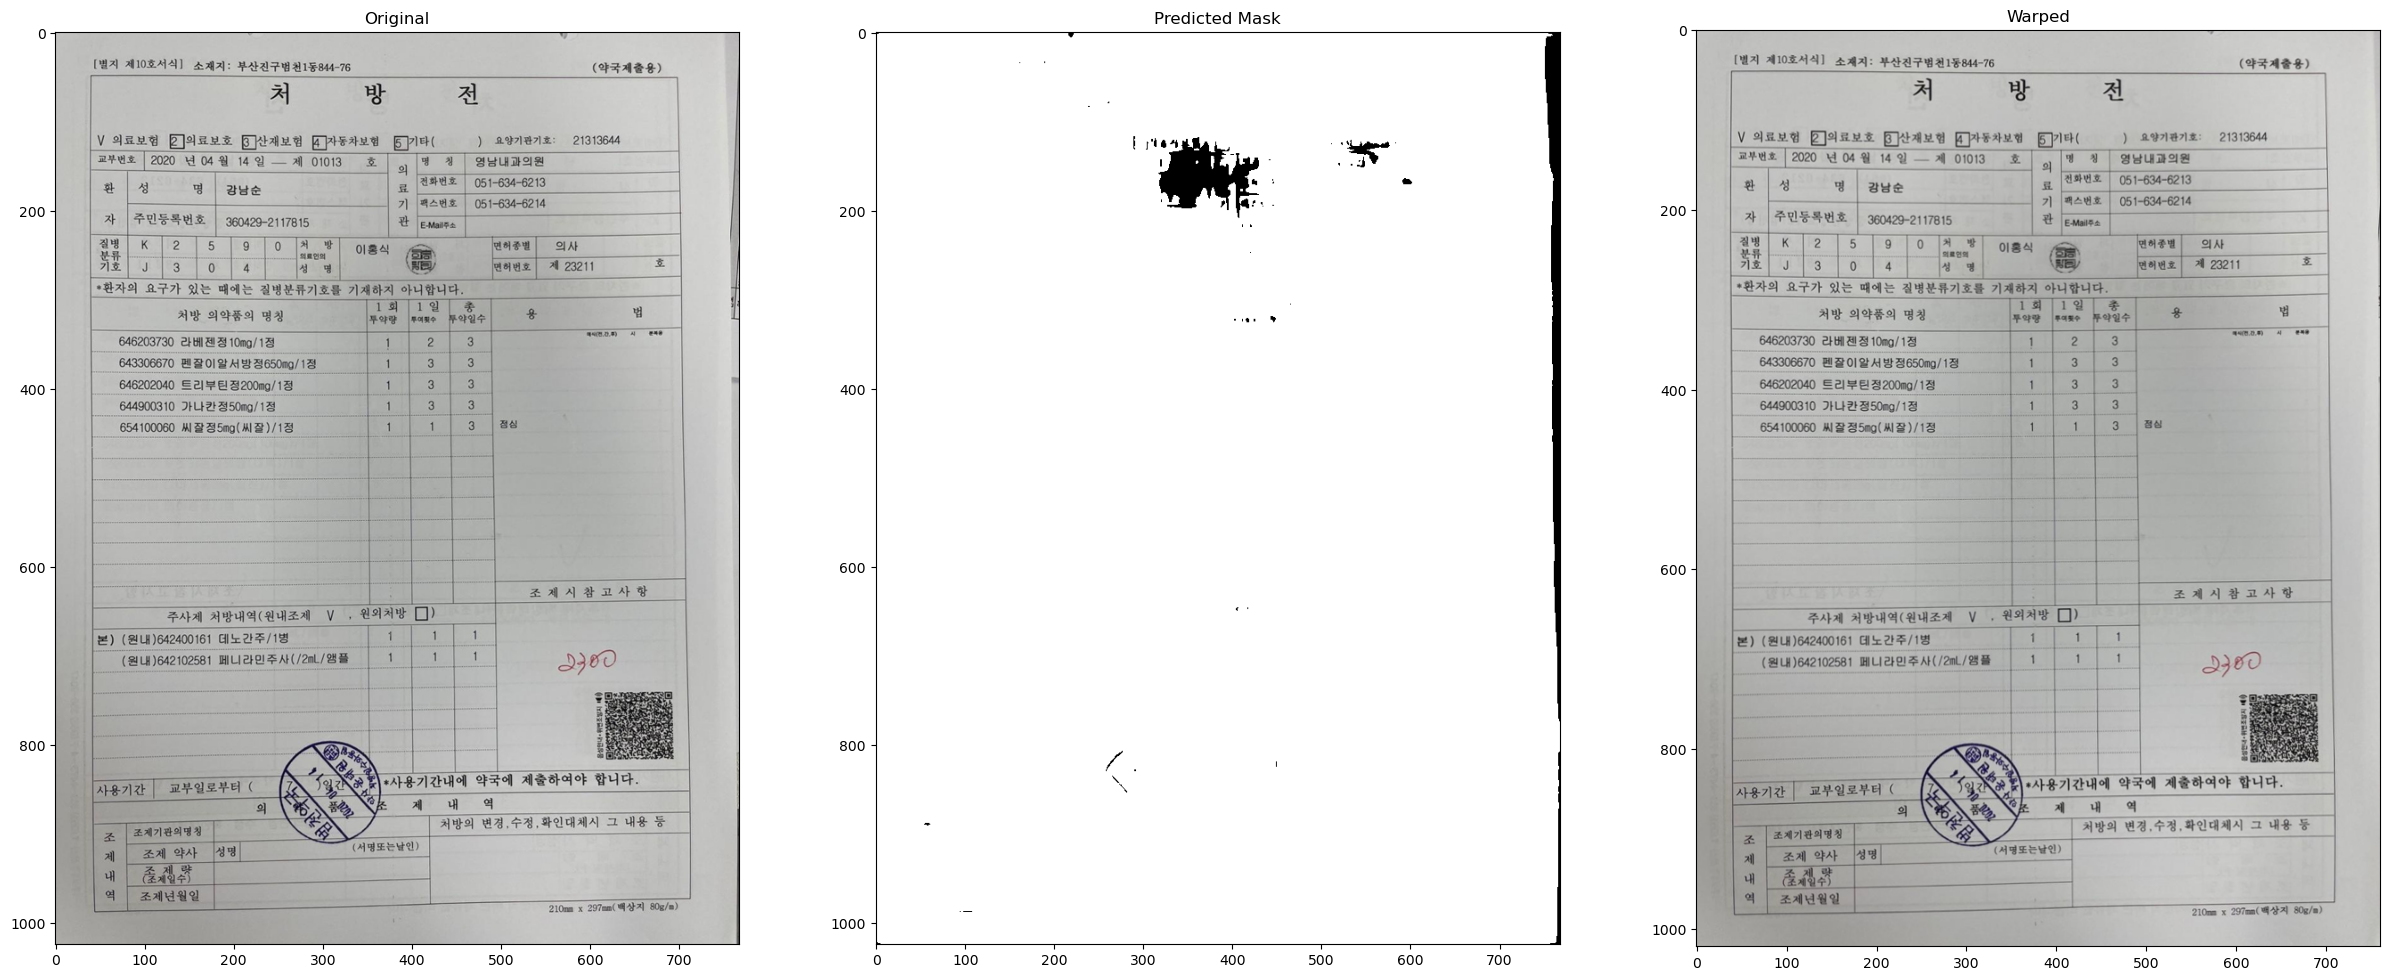

In [95]:
f, axarr = plt.subplots(1,3, figsize=(30,21))

i = -6
#cur_scan = scan_images[i]


axarr[0].imshow(im)
axarr[0].title.set_text('Original')

axarr[1].imshow(mask_det[0], cmap='gray')
axarr[1].title.set_text('Predicted Mask')

axarr[2].imshow(warped)
axarr[2].title.set_text('Warped')

# Make all masks

In [96]:
test_images_base_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/final_camera"
crop_images_save_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/final_crop"
#orig_folder = "final_camera"


from models.u2net import U2NETP, U2NET
segment = U2NETP(out_ch=1).to(device)

segmentation_model_path = './weights/mask_0326.pth'
segment.load_state_dict(torch.load(segmentation_model_path))

loader = transforms.Compose([transforms.ToTensor()])

In [97]:
num_pixels_x, num_pixels_y, num_channels = 1024, 768, 3

In [98]:
for test_img_path in sorted(os.listdir(test_images_base_path)):

    im = Image.open(f"{test_images_base_path}/{test_img_path}")
    im = ImageOps.exif_transpose(im)
    im = im.resize((num_pixels_y, num_pixels_x))
    im = np.array(im)

    
    image = loader(im).float()
    image = image.unsqueeze(0).to(device)
    

    with torch.no_grad():
        mask = segment(image)

    mask_det = torch.permute(mask[0].detach().cpu(), (0, 2,3, 1)).numpy()
    mask_det = mask_det>0.8

    mask_to_find = mask_det[0]
    mask_to_find = np.array(mask_to_find*255).astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask_to_find, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    simplified_contours = []

    try:
        for cnt in contours:
            hull = cv2.convexHull(cnt)
            simplified_contours.append(cv2.approxPolyDP(hull,
                                                        0.001 * cv2.arcLength(hull, True), True))
        biggest_n, approx_contour = biggest_contour(simplified_contours, 1000)

        warped = four_point_transform(im, approx_contour)

        PIL_image = Image.fromarray(warped.astype('uint8'), 'RGB')
        PIL_image.save(f"{crop_images_save_path}/{test_img_path}")
    except Exception as e:
        print(f"error: {e} -- file: {test_img_path}")

    #break

[[[ 758    2]]

 [[ 763 1021]]

 [[   2 1022]]

 [[   1    2]]]
---------
[[1.000e+00 2.000e+00]
 [7.580e+02 2.000e+00]
 [7.630e+02 1.021e+03]
 [2.000e+00 1.022e+03]]
[[[ 746    1]]

 [[ 730 1020]]

 [[   1 1021]]

 [[   0    1]]]
---------
[[0.000e+00 1.000e+00]
 [7.460e+02 1.000e+00]
 [7.300e+02 1.020e+03]
 [1.000e+00 1.021e+03]]
[[[ 72  35]]

 [[715  45]]

 [[740 974]]

 [[ 55 969]]]
---------
[[ 72.  35.]
 [715.  45.]
 [740. 974.]
 [ 55. 969.]]
[[[ 73  35]]

 [[706  65]]

 [[740 982]]

 [[ 49 981]]]
---------
[[ 73.  35.]
 [706.  65.]
 [740. 982.]
 [ 49. 981.]]
[[[737  59]]

 [[658 741]]

 [[ 75 736]]

 [[ 75  60]]]
---------
[[ 75.  60.]
 [737.  59.]
 [658. 741.]
 [ 75. 736.]]
[[[ 765    1]]

 [[ 736 1021]]

 [[   9 1022]]

 [[   5   18]]]
---------
[[5.000e+00 1.800e+01]
 [7.650e+02 1.000e+00]
 [7.360e+02 1.021e+03]
 [9.000e+00 1.022e+03]]
[[[ 764    1]]

 [[ 760 1021]]

 [[   3 1021]]

 [[   1    2]]]
---------
[[1.000e+00 2.000e+00]
 [7.640e+02 1.000e+00]
 [7.600e+02 1.021e+03]

[[[ 52  97]]

 [[676  99]]

 [[663 763]]

 [[ 64 750]]]
---------
[[ 52.  97.]
 [676.  99.]
 [663. 763.]
 [ 64. 750.]]
[[[117 152]]

 [[698 172]]

 [[660 798]]

 [[115 733]]]
---------
[[117. 152.]
 [698. 172.]
 [660. 798.]
 [115. 733.]]
[[[ 25  24]]

 [[737  49]]

 [[691 768]]

 [[ 24 762]]]
---------
[[ 25.  24.]
 [737.  49.]
 [691. 768.]
 [ 24. 762.]]
[[[ 58  39]]

 [[721  57]]

 [[683 718]]

 [[ 35 716]]]
---------
[[ 58.  39.]
 [721.  57.]
 [683. 718.]
 [ 35. 716.]]
[[[ 140   44]]

 [[ 615   49]]

 [[ 695 1021]]

 [[  45 1017]]]
---------
[[ 140.   44.]
 [ 615.   49.]
 [ 695. 1021.]
 [  45. 1017.]]
[[[ 761    2]]

 [[ 739 1020]]

 [[  56  997]]

 [[  20   59]]]
---------
[[  20.   59.]
 [ 761.    2.]
 [ 739. 1020.]
 [  56.  997.]]
[[[ 753    2]]

 [[ 764 1005]]

 [[  13 1012]]

 [[   1    3]]]
---------
[[1.000e+00 3.000e+00]
 [7.530e+02 2.000e+00]
 [7.640e+02 1.005e+03]
 [1.300e+01 1.012e+03]]
[[[ 66  66]]

 [[684  77]]

 [[652 741]]

 [[ 48 724]]]
---------
[[ 66.  66.]
 [684.  

[[[ 761    0]]

 [[ 722  995]]

 [[  31 1022]]

 [[   1    1]]]
---------
[[1.000e+00 1.000e+00]
 [7.610e+02 0.000e+00]
 [7.220e+02 9.950e+02]
 [3.100e+01 1.022e+03]]
[[[ 92  85]]

 [[711  89]]

 [[690 741]]

 [[104 743]]]
---------
[[ 92.  85.]
 [711.  89.]
 [690. 741.]
 [104. 743.]]
[[[ 55  93]]

 [[751 109]]

 [[646 799]]

 [[ 62 795]]]
---------
[[ 55.  93.]
 [751. 109.]
 [646. 799.]
 [ 62. 795.]]
[[[ 759    1]]

 [[ 758 1014]]

 [[  22 1008]]

 [[  41    3]]]
---------
[[4.100e+01 3.000e+00]
 [7.590e+02 1.000e+00]
 [7.580e+02 1.014e+03]
 [2.200e+01 1.008e+03]]
[[[ 765    2]]

 [[ 751 1020]]

 [[   6 1018]]

 [[  33    3]]]
---------
[[  33.    3.]
 [ 765.    2.]
 [ 751. 1020.]
 [   6. 1018.]]
[[[102 109]]

 [[691 126]]

 [[658 750]]

 [[ 91 735]]]
---------
[[102. 109.]
 [691. 126.]
 [658. 750.]
 [ 91. 735.]]
[[[112  38]]

 [[767  48]]

 [[697 716]]

 [[117 705]]]
---------
[[112.  38.]
 [767.  48.]
 [697. 716.]
 [117. 705.]]
[[[ 747   10]]

 [[ 767 1023]]

 [[   0 1023]]

 [[  78

[[[ 700    1]]

 [[ 766 1012]]

 [[   5  985]]

 [[  58   29]]]
---------
[[5.800e+01 2.900e+01]
 [7.000e+02 1.000e+00]
 [7.660e+02 1.012e+03]
 [5.000e+00 9.850e+02]]
[[[692  29]]

 [[754 974]]

 [[ 41 955]]

 [[ 81  46]]]
---------
[[ 81.  46.]
 [692.  29.]
 [754. 974.]
 [ 41. 955.]]
[[[ 155   30]]

 [[ 648   32]]

 [[ 708 1020]]

 [[  81 1018]]]
---------
[[ 155.   30.]
 [ 648.   32.]
 [ 708. 1020.]
 [  81. 1018.]]
[[[ 683    1]]

 [[ 744  970]]

 [[   2 1008]]

 [[   1    2]]]
---------
[[1.000e+00 2.000e+00]
 [6.830e+02 1.000e+00]
 [7.440e+02 9.700e+02]
 [2.000e+00 1.008e+03]]
[[[701  41]]

 [[715 962]]

 [[ 43 961]]

 [[ 72  42]]]
---------
[[ 72.  42.]
 [701.  41.]
 [715. 962.]
 [ 43. 961.]]
[[[ 60  26]]

 [[739  35]]

 [[690 742]]

 [[ 64 733]]]
---------
[[ 60.  26.]
 [739.  35.]
 [690. 742.]
 [ 64. 733.]]
[[[ 46  82]]

 [[726 101]]

 [[586 754]]

 [[ 54 782]]]
---------
[[ 46.  82.]
 [726. 101.]
 [586. 754.]
 [ 54. 782.]]
[[[ 613   34]]

 [[ 697 1002]]

 [[  78 1016]]

 [[ 138

[[[751  64]]

 [[697 815]]

 [[ 22 821]]

 [[ 28  71]]]
---------
[[ 28.  71.]
 [751.  64.]
 [697. 815.]
 [ 22. 821.]]
[[[ 764    1]]

 [[ 767 1023]]

 [[   2 1022]]

 [[   2    2]]]
---------
[[2.000e+00 2.000e+00]
 [7.640e+02 1.000e+00]
 [7.670e+02 1.023e+03]
 [2.000e+00 1.022e+03]]
[[[ 766    0]]

 [[ 758 1020]]

 [[  13 1021]]

 [[   1    3]]]
---------
[[1.000e+00 3.000e+00]
 [7.660e+02 0.000e+00]
 [7.580e+02 1.020e+03]
 [1.300e+01 1.021e+03]]
[[[740  49]]

 [[738 725]]

 [[114 723]]

 [[102  50]]]
---------
[[102.  50.]
 [740.  49.]
 [738. 725.]
 [114. 723.]]
[[[ 93  67]]

 [[755  67]]

 [[724 778]]

 [[ 66 752]]]
---------
[[ 93.  67.]
 [755.  67.]
 [724. 778.]
 [ 66. 752.]]
[[[690  44]]

 [[691 708]]

 [[ 68 733]]

 [[ 50  65]]]
---------
[[ 50.  65.]
 [690.  44.]
 [691. 708.]
 [ 68. 733.]]
[[[705   1]]

 [[767 996]]

 [[ 21 982]]

 [[ 61  32]]]
---------
[[ 61.  32.]
 [705.   1.]
 [767. 996.]
 [ 21. 982.]]
[[[705   1]]

 [[767 996]]

 [[ 21 982]]

 [[ 61  32]]]
---------
[[ 61

[[[ 95  48]]

 [[725  50]]

 [[752 969]]

 [[ 96 944]]]
---------
[[ 95.  48.]
 [725.  50.]
 [752. 969.]
 [ 96. 944.]]
[[[ 682   36]]

 [[ 767  984]]

 [[  13 1004]]

 [[  61   39]]]
---------
[[  61.   39.]
 [ 682.   36.]
 [ 767.  984.]
 [  13. 1004.]]
[[[ 47  57]]

 [[706  90]]

 [[664 751]]

 [[ 49 749]]]
---------
[[ 47.  57.]
 [706.  90.]
 [664. 751.]
 [ 49. 749.]]
[[[721  80]]

 [[698 772]]

 [[ 75 759]]

 [[ 44  82]]]
---------
[[ 44.  82.]
 [721.  80.]
 [698. 772.]
 [ 75. 759.]]
[[[ 612   39]]

 [[ 675 1006]]

 [[  78 1005]]

 [[ 134   42]]]
---------
[[ 134.   42.]
 [ 612.   39.]
 [ 675. 1006.]
 [  78. 1005.]]
[[[ 151   26]]

 [[ 661   54]]

 [[ 677 1020]]

 [[ 141  996]]]
---------
[[ 151.   26.]
 [ 661.   54.]
 [ 677. 1020.]
 [ 141.  996.]]
[[[ 595    8]]

 [[ 700  980]]

 [[  62 1017]]

 [[ 115   17]]]
---------
[[ 115.   17.]
 [ 595.    8.]
 [ 700.  980.]
 [  62. 1017.]]
[[[ 129   17]]

 [[ 623   29]]

 [[ 718 1021]]

 [[  58 1018]]]
---------
[[ 129.   17.]
 [ 623.   29.]

[[[  9  22]]

 [[698  75]]

 [[739 988]]

 [[ 95 950]]]
---------
[[  9.  22.]
 [698.  75.]
 [739. 988.]
 [ 95. 950.]]
[[[ 90  19]]

 [[672  24]]

 [[715 878]]

 [[ 53 883]]]
---------
[[ 90.  19.]
 [672.  24.]
 [715. 878.]
 [ 53. 883.]]
[[[ 620    0]]

 [[ 733 1016]]

 [[  51 1019]]

 [[ 120    2]]]
---------
[[ 120.    2.]
 [ 620.    0.]
 [ 733. 1016.]
 [  51. 1019.]]
[[[ 716    1]]

 [[ 767 1016]]

 [[   2 1006]]

 [[  51   16]]]
---------
[[5.100e+01 1.600e+01]
 [7.160e+02 1.000e+00]
 [7.670e+02 1.016e+03]
 [2.000e+00 1.006e+03]]
[[[664  36]]

 [[698 931]]

 [[ 60 928]]

 [[ 34  44]]]
---------
[[ 34.  44.]
 [664.  36.]
 [698. 931.]
 [ 60. 928.]]
[[[ 696    9]]

 [[ 767  996]]

 [[   1 1020]]

 [[  20    2]]]
---------
[[2.00e+01 2.00e+00]
 [6.96e+02 9.00e+00]
 [7.67e+02 9.96e+02]
 [1.00e+00 1.02e+03]]
[[[ 79  47]]

 [[706  54]]

 [[733 971]]

 [[ 52 965]]]
---------
[[ 79.  47.]
 [706.  54.]
 [733. 971.]
 [ 52. 965.]]
[[[ 658    7]]

 [[ 740 1020]]

 [[  60 1020]]

 [[ 151    9]]]

[[[ 92  34]]

 [[670  52]]

 [[736 940]]

 [[  4 914]]]
---------
[[ 92.  34.]
 [670.  52.]
 [736. 940.]
 [  4. 914.]]
[[[710  16]]

 [[757 978]]

 [[ 29 946]]

 [[ 38   3]]]
---------
[[ 38.   3.]
 [710.  16.]
 [757. 978.]
 [ 29. 946.]]
[[[ 704    4]]

 [[ 756 1020]]

 [[   3  977]]

 [[  69   39]]]
---------
[[  69.   39.]
 [ 704.    4.]
 [ 756. 1020.]
 [   3.  977.]]
[[[  42    2]]

 [[ 737   77]]

 [[ 739 1022]]

 [[  16  966]]]
---------
[[  42.    2.]
 [ 737.   77.]
 [ 739. 1022.]
 [  16.  966.]]
[[[ 23   1]]

 [[679   8]]

 [[756 972]]

 [[ 88 939]]]
---------
[[ 23.   1.]
 [679.   8.]
 [756. 972.]
 [ 88. 939.]]
[[[ 46  36]]

 [[671  38]]

 [[701 944]]

 [[ 36 953]]]
---------
[[ 46.  36.]
 [671.  38.]
 [701. 944.]
 [ 36. 953.]]
[[[ 655    2]]

 [[ 696 1018]]

 [[ 182 1017]]

 [[ 113    5]]]
---------
[[ 113.    5.]
 [ 655.    2.]
 [ 696. 1018.]
 [ 182. 1017.]]
[[[ 605   25]]

 [[ 694  990]]

 [[  74 1009]]

 [[ 139   31]]]
---------
[[ 139.   31.]
 [ 605.   25.]
 [ 694.  990.]


[[[ 55  21]]

 [[711  23]]

 [[739 992]]

 [[ 34 992]]]
---------
[[ 55.  21.]
 [711.  23.]
 [739. 992.]
 [ 34. 992.]]
[[[ 641    1]]

 [[ 726 1002]]

 [[  82 1015]]

 [[ 150    2]]]
---------
[[1.500e+02 2.000e+00]
 [6.410e+02 1.000e+00]
 [7.260e+02 1.002e+03]
 [8.200e+01 1.015e+03]]
[[[ 89 117]]

 [[689 143]]

 [[642 772]]

 [[ 66 765]]]
---------
[[ 89. 117.]
 [689. 143.]
 [642. 772.]
 [ 66. 765.]]
[[[ 52  33]]

 [[758  41]]

 [[633 747]]

 [[ 31 739]]]
---------
[[ 52.  33.]
 [758.  41.]
 [633. 747.]
 [ 31. 739.]]
[[[   7    3]]

 [[ 763   19]]

 [[ 767 1023]]

 [[   2 1020]]]
---------
[[   7.    3.]
 [ 763.   19.]
 [ 767. 1023.]
 [   2. 1020.]]
[[[  17   12]]

 [[ 741   33]]

 [[ 695 1022]]

 [[   6 1007]]]
---------
[[  17.   12.]
 [ 741.   33.]
 [ 695. 1022.]
 [   6. 1007.]]
[[[145  29]]

 [[624  51]]

 [[757 993]]

 [[ 35 970]]]
---------
[[145.  29.]
 [624.  51.]
 [757. 993.]
 [ 35. 970.]]
[[[ 122   21]]

 [[ 630   23]]

 [[ 666 1016]]

 [[  98 1020]]]
---------
[[ 122.   21.

In [ ]:
김형순_2
김용국_2

In [ ]:

def biggest_contour(contours, min_area):
    biggest = None
    max_area = 0
    biggest_n = 0
    approx_contour = None
    for n, i in enumerate(contours):
        area = cv2.contourArea(i)

        if area > min_area / 30:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
                biggest_n = n
                approx_contour = approx

    return biggest_n, approx_contour


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    pts = pts.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


# ## Find the exact (x,y) coordinates of the biggest contour and crop it out


def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    print(pts)
    rect = order_points(pts)
    print("---------")
    print(rect)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

# Make numpy arrays

In [53]:
crop_images_save_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/final_crop"
scan_images_base_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/final_scan"

In [61]:
num_pixels_x, num_pixels_y, num_channels = 1024//1, 768//1, 3

crop_images = np.zeros((len(os.listdir(crop_images_save_path)), num_pixels_x, num_pixels_y, num_channels), dtype=np.uint8)
scan_images = np.zeros((len(os.listdir(crop_images_save_path)), num_pixels_x, num_pixels_y, num_channels), dtype=np.uint8)

In [63]:
from tqdm import tqdm
for count, im_path in enumerate(tqdm(sorted(os.listdir(crop_images_save_path)))):

    im_crop = Image.open(f"{crop_images_save_path}/{im_path}").convert('RGB')
    im_scan = Image.open(f"{scan_images_base_path}/{im_path}").convert('RGB')
    
    im_crop = ImageOps.exif_transpose(im_crop)
    im_scan = ImageOps.exif_transpose(im_scan)
    
    im_crop = im_crop.resize((num_pixels_y, num_pixels_x))
    im_scan = im_scan.resize((num_pixels_y, num_pixels_x))
    
    im_crop = np.array(im_crop)
    im_scan = np.array(im_scan)

    crop_images[count] = im_crop
    scan_images[count] = im_scan
    #print(i)

100%|████████████████████████████████████████████████████████████████████████████████| 363/363 [00:41<00:00,  8.71it/s]


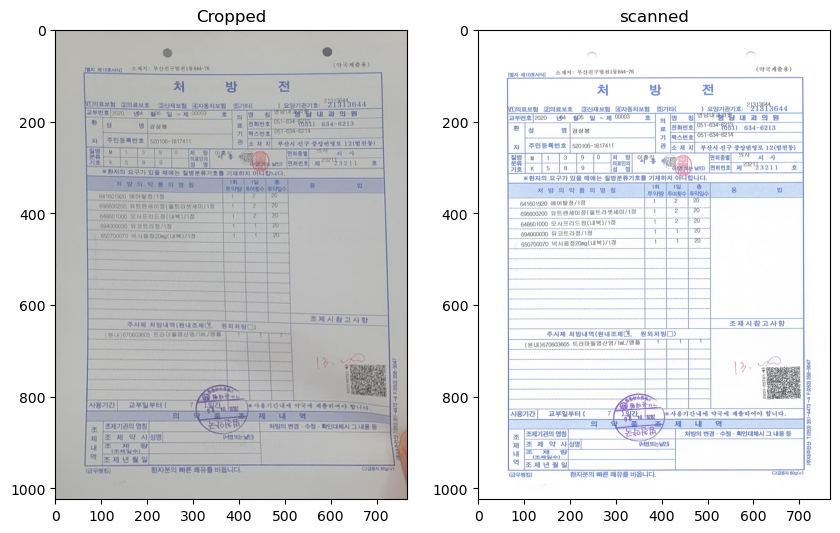

In [68]:
f, axarr = plt.subplots(1,2, figsize=(10,7))

i = 1


cur_orig = crop_images[i]
cur_mask = scan_images[i]


axarr[0].imshow(cur_orig)
axarr[0].title.set_text('Cropped')

axarr[1].imshow(cur_mask, cmap='gray')
axarr[1].title.set_text('scanned')

In [70]:
base_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination"

pixel_size = 1024

    
with open(f"{base_path}/crop_{pixel_size}.npy", 'wb') as f:
    np.save(f, crop_images)
    
with open(f"{base_path}/scan_{pixel_size}.npy", 'wb') as f:
    np.save(f, scan_images)
    
    

    
# with open(f"{base_path}/orig_{pixel_size}.npy", 'rb') as f:
#     orig_images = np.load(f)
    
# with open(f"{base_path}/mask_{pixel_size}.npy", 'rb') as f:
#     mask_images = np.load(f)    